In [10]:

from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error

import tensorflow as tfa

import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [11]:
data = pd.read_excel('Natural_Gas_Spot_Price.xlsx')
data.info()

data = data.rename(
    columns={
        "Henry Hub Natural Gas Spot Price (Dollars per Million Btu)":"gas_price",
        "Date":"date"
    }
)

data = data.fillna(method = 'pad')

data['date'] = pd.to_datetime(data['date'], format = "%d/%m/%Y")
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6505 entries, 0 to 6504
Data columns (total 2 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   Date                                                        6505 non-null   datetime64[ns]
 1   Henry Hub Natural Gas Spot Price (Dollars per Million Btu)  6504 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 101.8 KB


,date,gas_price
0,1997-01-07,3.82
1,1997-01-08,3.80
2,1997-01-09,3.61
3,1997-01-10,3.92
4,1997-01-13,4.00
...,...,...
6500,2022-11-09,3.46
6501,2022-11-10,4.80
6502,2022-11-11,4.80
6503,2022-11-14,6.24


In [12]:
weather = pd.read_csv('lafayettetempdata.csv')

weather = weather.rename(
    columns={
        "TMIN (Degrees Fahrenheit)":"TMIN",
        "Date":"date"
    }
)

weather['date'] = pd.to_datetime(weather['date'],errors='coerce')
weather["date"] = weather["date"].dt.strftime("%Y-%m-%d")
weather['date'] = pd.to_datetime(weather['date'], format = "%Y-%m-%d")
# weather['date'] = pd.to_datetime(weather['date'], format = "%d/%m/%Y")
weather

,date,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN,PRCP (Inches),SNOW (Inches),SNWD (Inches)
0,1893-01-01,NaN,57.0,40.0,0.01,0.0,NaN
1,1893-01-02,NaN,71.0,37.0,NaN,0.0,NaN
2,1893-01-03,NaN,64.0,39.0,NaN,0.0,NaN
3,1893-01-04,NaN,70.0,38.0,NaN,0.0,NaN
4,1893-01-05,NaN,70.0,41.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...
47504,2023-02-24,NaN,82.0,72.0,0.00,0.0,NaN
47505,2023-02-25,NaN,83.0,68.0,0.00,0.0,NaN
47506,2023-02-26,NaN,79.0,68.0,0.00,0.0,NaN
47507,2023-02-27,NaN,82.0,68.0,0.00,0.0,NaN


In [13]:
merged_df = pd.merge(data, weather[['date', 'TMIN']], on='date', how='left')
merged_df

,date,gas_price,TMIN
0,1997-01-07,3.82,40.0
1,1997-01-08,3.80,39.0
2,1997-01-09,3.61,32.0
3,1997-01-10,3.92,31.0
4,1997-01-13,4.00,30.0
...,...,...,...
6500,2022-11-09,3.46,61.0
6501,2022-11-10,4.80,52.0
6502,2022-11-11,4.80,51.0
6503,2022-11-14,6.24,39.0


In [14]:
missing_values = merged_df.isnull().sum()

print(missing_values)

date         0
gas_price    0
TMIN         5
dtype: int64


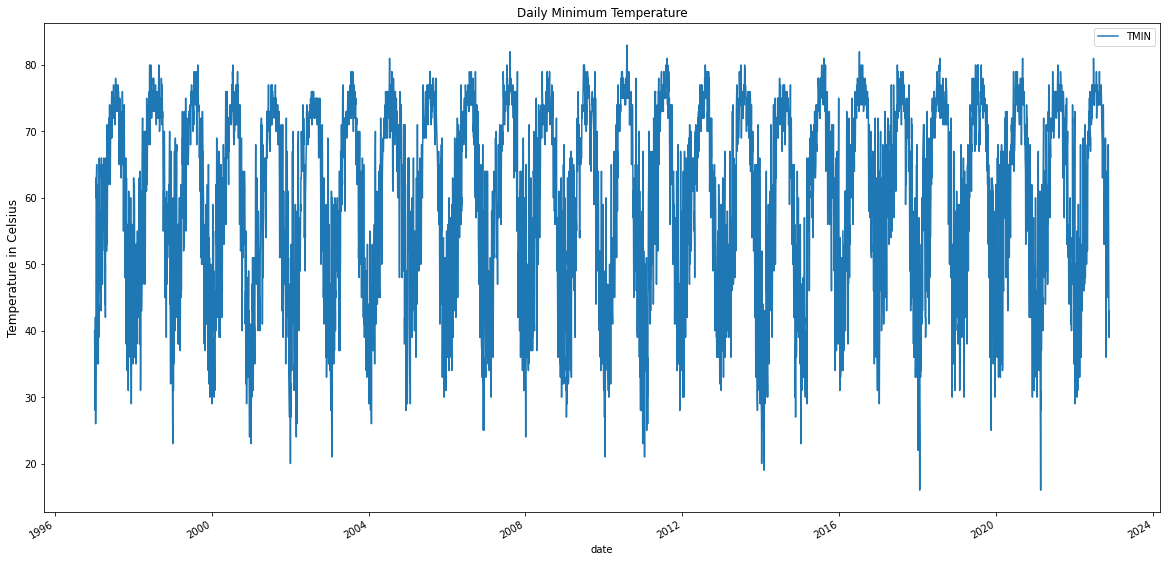

In [15]:
merged_df.plot(figsize=(20, 10),x='date', y='TMIN')
plt.title('Daily Minimum Temperature', fontsize=12)
plt.ylabel('Temperature in Celsius', fontsize=12)
plt.show()

In [16]:
merged_df = merged_df.rename(
    columns={
        "gas_price":"y",
        "date":"ds"
    }
)
merged_df

,ds,y,TMIN
0,1997-01-07,3.82,40.0
1,1997-01-08,3.80,39.0
2,1997-01-09,3.61,32.0
3,1997-01-10,3.92,31.0
4,1997-01-13,4.00,30.0
...,...,...,...
6500,2022-11-09,3.46,61.0
6501,2022-11-10,4.80,52.0
6502,2022-11-11,4.80,51.0
6503,2022-11-14,6.24,39.0


In [17]:
merged_df.set_index('ds', inplace=True)

# Use linear interpolation to impute missing values
merged_df['TMIN'] = merged_df['TMIN'].interpolate(method='linear')

# Reset the index to default and save the dataframe
merged_df = merged_df.reset_index()

In [18]:
merged_df

,ds,y,TMIN
0,1997-01-07,3.82,40.0
1,1997-01-08,3.80,39.0
2,1997-01-09,3.61,32.0
3,1997-01-10,3.92,31.0
4,1997-01-13,4.00,30.0
...,...,...,...
6500,2022-11-09,3.46,61.0
6501,2022-11-10,4.80,52.0
6502,2022-11-11,4.80,51.0
6503,2022-11-14,6.24,39.0


In [19]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [20]:
listt = []
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 1],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10],
    'holidays_prior_scale': [0.01, 0.1, 1, 10],
    'changepoint_range' : [0.01, 0.05, 0.1, 0.5, 1.0]

}
# for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
#     for seasonality_prior_scale in param_grid['seasonality_prior_scale']:
#         for holidays_prior_scale in param_grid['holidays_prior_scale']:
# 0.001, 0.1, 0.1
# for changepoint_range in param_grid['changepoint_range']:

model = Prophet(changepoint_prior_scale=0.001,seasonality_prior_scale = 0.1, holidays_prior_scale=0.1, changepoint_range=0.01)
model.add_regressor('TMIN')
model.fit(merged_df)
new_temp = weather['1997-01-07':'2023-02-23']
new_temp['TMIN'] = new_temp['TMIN'].interpolate(method='linear')
new_temp = new_temp.reset_index()
future_df = model.make_future_dataframe(periods=100)
future_df['TMIN'] = new_temp['TMIN'] # use temperature data for future predictions
forecast = model.predict(future_df)
forecast = forecast.tail(100).reset_index()
dates = pd.date_range(start='2022-11-16', periods=100, freq='D')
dates = pd.DataFrame(dates)
dates['predicted_mean'] = forecast['yhat'].tail(100)
dates['yhat_upper'] = forecast['yhat_upper'].tail(100)
dates['yhat_lower'] = forecast['yhat_lower'].tail(100)
dates.columns.values[0] = 'date'

# print(dates)

data1 = pd.read_csv('forecast.csv')
data1 = data1.drop('predicted_mean', axis=1)

dates['date'] = pd.to_datetime(dates['date'])
data1['date'] = pd.to_datetime(data1['date'])

df_merged = pd.merge(data1, dates[['date', 'predicted_mean','yhat_upper','yhat_lower']], on='date', how='inner')
df_merged
from sklearn.metrics import mean_squared_error

# import matplotlib.dates as mdates
plt.figure(figsize = (20, 10))
# plt.plot(train,color = 'black',label = "train")
plt.plot(df_merged['gas_price'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(df_merged['predicted_mean'], color = 'blue', label = 'SARIMA Predicted Price')
plt.fill_between(df_merged.index,df_merged['yhat_lower'] ,df_merged['yhat_upper']  , color='k', alpha=.2, label='Confidence Interval')
plt.title("Natural Gas Price Prediction on Test Data")
plt.xlabel('days',fontsize=20)
plt.ylabel('Natural gas price',fontsize=20)
plt.legend(loc = 'best',fontsize=20)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('days')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()
# print(mean_squared_error(df_merged['gas_price'], df_merged['predicted_mean']), changepoint_range)
# listt.append([mean_squared_error(df_merged['gas_price'], df_merged['predicted_mean']),changepoint_range])


11:33:09 - cmdstanpy - INFO - Chain [1] start processing
11:33:10 - cmdstanpy - INFO - Chain [1] done processing


An error occurred: cannot do slice indexing on RangeIndex with these indexers [1997-01-07] of type str


In [21]:
data_sorted = sorted(listt, key=lambda x: x[0])

# print the sorted list
print(data_sorted)

[]
